### **1. Import Package**

In [1]:
!pip install pandas-plink
!pip install dask-ml --quiet

In [2]:
from pandas_plink import read_plink
from sklearn.metrics import pairwise_distances
import dask.array as da
import numpy as np
import numpy as np
import pandas as pd
import random
import time

###**2. Load Data PLINK**

In [5]:
!gunzip -k /content/core_v0.7.bed.gz
!gunzip -k /content/core_v0.7.bim.gz
!gunzip -k /content/core_v0.7.fam.gz

gzip: /content/core_v0.7.bim already exists; do you wish to overwrite (y or n)? y
gzip: /content/core_v0.7.fam already exists; do you wish to overwrite (y or n)? y


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
bim, fam, bed = read_plink("core_v0.7")

# bed → matrix genotipe ukuran: variants × samples
# fam → informasi sampel (ID individu)
# bim → informasi SNP (chrom, posisi, allele)

# Sandi Genotipe:
# 0 = homozigot referensi
# 1 = heterozigot
# 2 = homozigot alternatif
# -1 = missing

print("SNPs:", bed.shape[0])
print("Samples:", bed.shape[1])
# print(type(bed))
# print(bed)

small_view = bed[:5, :].compute()
print(small_view)
print(fam.head())
print(bim.head())

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]
/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


SNPs: 404388
Samples: 3024
[[2. 2. 2. ... 0. 0. 2.]
 [2. 2. 2. ... 0. 0. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 0. 0. 2.]]
    fid   iid father mother gender trait  i
0  B001  B001      0      0      0    -9  0
1  B002  B002      0      0      0    -9  1
2  B003  B003      0      0      0    -9  2
3  B004  B004      0      0      0    -9  3
4  B005  B005      0      0      0    -9  4
  chrom   snp   cm   pos a0 a1  i
0     1  1178  0.0  1178  T  G  0
1     1  1203  0.0  1203  C  T  1
2     1  1248  0.0  1248  A  G  2
3     1  1282  0.0  1282  A  G  3
4     1  1299  0.0  1299  C  T  4


### **3. Preprocessing**

In [8]:
# Matriks Genotipe
G0 = bed       # (variants × samples)

# Mengubah Missing Genotype Menjadi NaN
G_filled = da.where(G0 < 0, da.nan, G0)
# Mengimputasi Genotipe yang Missing dengan Rata-rata SNP
snp_mean = da.nanmean(G_filled, axis=1, keepdims=True)
G_filled = da.where(da.isnan(G_filled), snp_mean, G_filled)

# Standardisasi per SNP
snp_std = da.std(G_filled, axis=1, keepdims=True)
G_std = (G_filled - snp_mean) / (snp_std + 1e-8)


### **4. Pembuatan Genomic Relationship Matrix (GRM)**

In [9]:
# Hitung M = jumlah SNP
M = G_std.shape[0]

# Membuat GRM (Genomic Relationship Matrix)
# GRM = “kinship matrix genomik” → Mengukur kedekatan genetik antar-individu.
GRM = (G_std.T @ G_std) / M
GRM = GRM.compute()

### **5. PCA (Principal Component Analysis)**



---
Fungsi PCA untuk Parent Selection dalam breeding atau optimisasi pemilihan induk (parent selection):
1.   Mengidentifikasi struktur populasi
2.   Meminimalkan inbreeding
3.   Meningkatkan diversitas genetik

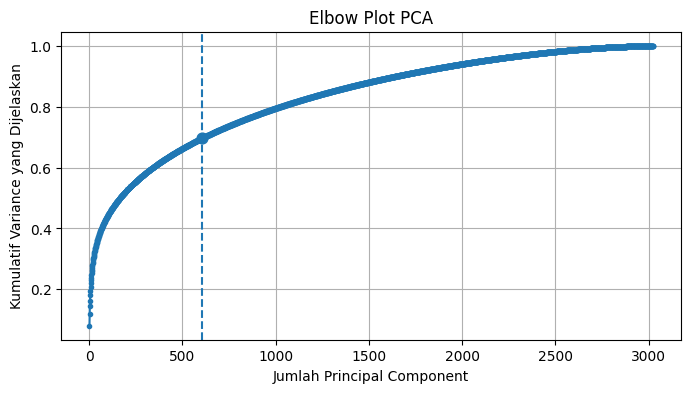

Jumlah PC optimal (metode elbow) ≈ 602
Kumulatif variance pada PC 602: 69.57%
Shape PC yang dipakai: (3024, 602)
Shape dist_matrix: (3024, 3024)


In [10]:
# --- Setelah GRM = GRM.compute() ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# 1. PCA dari GRM
vals, vecs = np.linalg.eigh(GRM)
idx = np.argsort(vals)[::-1]
eigenvalues = vals[idx]
PC = vecs[:, idx]

# 2. Explained & cumulative variance
total_var = np.sum(eigenvalues)
var_explained = eigenvalues / total_var
cum_var_explained = np.cumsum(var_explained)

# 3. Elbow plot (semua PC)
max_pc_plot = len(eigenvalues)
x = np.arange(1, max_pc_plot + 1)
y = cum_var_explained[:max_pc_plot]

plt.figure(figsize=(8, 4))
plt.plot(x, y, marker='.')
plt.xlabel('Jumlah Principal Component')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Elbow Plot PCA')
plt.grid(True)

# 4. Cari titik siku (elbow) otomatis
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])
line_vec = p2 - p1
line_norm = np.linalg.norm(line_vec)

distances = []
for i in range(len(x)):
    p = np.array([x[i], y[i]])
    dist = np.abs(np.cross(line_vec, p - p1)) / line_norm
    distances.append(dist)

distances = np.array(distances)
elbow_idx = np.argmax(distances)
n_pc_elbow = x[elbow_idx]

plt.scatter([n_pc_elbow], [y[elbow_idx]], s=60)
plt.axvline(n_pc_elbow, linestyle='--')
plt.show()

print(f"Jumlah PC optimal (metode elbow) ≈ {n_pc_elbow}")
print(f"Kumulatif variance pada PC {n_pc_elbow}: {y[elbow_idx]*100:.2f}%")

# 5. PC yang dipakai untuk GA
PC_use = PC[:, :n_pc_elbow]

# 6. Jarak genetik sebagai input GA
dist_matrix = pairwise_distances(PC_use)
print("Shape PC yang dipakai:", PC_use.shape)
print("Shape dist_matrix:", dist_matrix.shape)


### **6. Hitung jarak genetik dari PC20**

In [11]:
# # Menghitung jarak genetik antar calon induk
# dist_matrix = pairwise_distances(PC20)

print(dist_matrix.shape)   # (n_samples, n_samples)
print(fam.shape)           # (n_samples, 7)


(3024, 3024)
(3024, 7)


### **7. Genetic Algorithm (GA)**

Start GA...
Gen 000 | best=0.8534 | mean=0.6189
Gen 010 | best=1.0414 | mean=0.9904
Gen 020 | best=1.0414 | mean=1.0066
Gen 030 | best=1.0869 | mean=1.0427
Gen 040 | best=1.0869 | mean=1.0477
Gen 050 | best=1.0869 | mean=1.0492
Gen 060 | best=1.0869 | mean=1.0512
Gen 070 | best=1.0920 | mean=1.0590
Gen 080 | best=1.0960 | mean=1.0523
Gen 090 | best=1.0960 | mean=1.0639
Gen 100 | best=1.0960 | mean=1.0487
Gen 110 | best=1.0960 | mean=1.0432
Gen 120 | best=1.0960 | mean=1.0652
Gen 130 | best=1.0960 | mean=1.0552
Gen 140 | best=1.0960 | mean=1.0575
Gen 150 | best=1.0960 | mean=1.0534
Gen 160 | best=1.0960 | mean=1.0446
Gen 170 | best=1.0960 | mean=1.0649
Gen 180 | best=1.0960 | mean=1.0475
Gen 190 | best=1.0960 | mean=1.0530
GA done in 0.39s


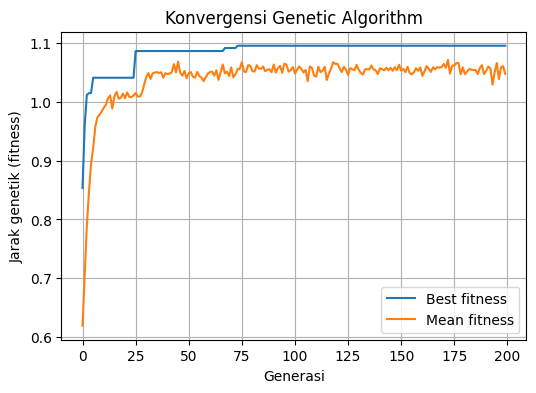

In [55]:
# ---------------------------------------------------
# Inputan
# dist_matrix = pairwise_distances(PC20) >jarak genetik antar individu hasil PCA
# fam = fam dari read_plink(...)
# ---------------------------------------------------

n_samples = dist_matrix.shape[0]
sample_ids = fam.iid.values

# -------------------------------
# 1. Fitness function
# Fitness → jarak genetik antar pasangan.
# -------------------------------
def fitness(pair):
    i, j = pair     #sepasang individu.
    return float(dist_matrix[i, j])     # Semakin besar jaraknya → semakin “bagus” (mengurangi inbreeding).

# -------------------------------
# 2. Komponen Genetic Algorithm (GA)
# -------------------------------
# Membuat pasangan acak
def random_pair():
    a = random.randrange(n_samples)
    b = random.randrange(n_samples)
    while b == a:
        b = random.randrange(n_samples)
    return (a, b)

def crossover(p1, p2):
    # permisalan sederhana Menggabungkan dua pasangan “parent” → menghasilkan pasangan baru.
    return (p1[0], p2[1])

# Mengubah anggota pasangan secara acak dengan probabilitas mut_rate
def mutate(pair, mut_rate=0.1):
    a, b = pair
    if random.random() < mut_rate:
        a = random.randrange(n_samples)
    if random.random() < mut_rate:
        b = random.randrange(n_samples)
    while b == a:
        b = random.randrange(n_samples)
    return (a, b)

# Memilih kandidat terbaik dari k acak dalam populasi → meniru seleksi alam.
def tournament_select(pop, fitness_scores, k=3):
    idxs = random.sample(range(len(pop)), k)
    best = max(idxs, key=lambda i: fitness_scores[i])
    return pop[best]

# -------------------------------
# 3. GA Hyperparameters
# -------------------------------
POP = 200       # populasi pasangan
GEN = 200       # jumlah generasi
ELITE = int(0.1 * POP) # elitism: top 10% langsung lanjut ke generasi berikut
K_TOUR = 3      # ukuran turnamen
MUT = 0.1       # probabilitas mutasi

# -------------------------------
# 4. Initial population
# -------------------------------
population = [random_pair() for _ in range(POP)]

print("Start GA...")
t0 = time.time()

best_history = []
mean_history = []

# Evolusi GA
for g in range(GEN):

    scores = [fitness(ind) for ind in population]

    # sort by score desc
    order = np.argsort(scores)[::-1]
    population = [population[i] for i in order]
    scores = [scores[i] for i in order]

    best_val = scores[0]
    mean_val = np.mean(scores)

    best_history.append(best_val)
    mean_history.append(mean_val)

    if g % 10 == 0:
        print(f"Gen {g:03d} | best={best_val:.4f} | mean={mean_val:.4f}")

    # elitism
    new_population = population[:ELITE]

    # fill with mating
    while len(new_population) < POP:
        p1 = tournament_select(population, scores, k=K_TOUR)
        p2 = tournament_select(population, scores, k=K_TOUR)
        child = crossover(p1, p2)
        child = mutate(child, MUT)
        new_population.append(child)

    population = new_population

t1 = time.time()
print(f"GA done in {t1-t0:.2f}s")

# -------------------------------
# 5. Ambil sampai 30 pasangan terbaik
# -------------------------------
MAX_TOP = 30

final = [(ind, fitness(ind)) for ind in population]
final = sorted(final, key=lambda x: x[1], reverse=True)

top = []
seen = set()

for pair, sc in final:
    if pair not in seen and (pair[1], pair[0]) not in seen:
        top.append((pair, sc))
        seen.add(pair)
    if len(top) == MAX_TOP:
        break

# -------------------------------
# 6. Plot Konvergensi GA
# -------------------------------
import matplotlib.pyplot as plt

gens = range(len(best_history))

print(f"\n\nPlot Konvergensi GA {t1-t0:.2f}s")
plt.figure(figsize=(6,4))
plt.plot(gens, best_history, label='Best fitness')
plt.plot(gens, mean_history, label='Mean fitness')
plt.xlabel('Generasi')
plt.ylabel('Jarak genetik (fitness)')
plt.title('Konvergensi Genetic Algorithm')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# -------------------------------
# 6. Dataframe Hasil
# -------------------------------
rows = []
for (i, j), sc in top:
    rows.append({
        "idx1": i,
        "idx2": j,
        "ID1": sample_ids[i],
        "ID2": sample_ids[j],
        "distance": sc
    })

df_results = pd.DataFrame(rows)
df_results

,idx1,idx2,ID1,ID2,distance
0,2292,2355,IRIS_313-11413,IRIS_313-11489,1.095965
1,2292,1430,IRIS_313-11413,IRIS_313-10396,1.005537
2,2292,2413,IRIS_313-11413,IRIS_313-11564,1.001747
3,2292,1753,IRIS_313-11413,IRIS_313-10858,0.985652
4,2292,2582,IRIS_313-11413,IRIS_313-11762,0.962962
5,2292,1094,IRIS_313-11413,IRIS_313-9357,0.957718
6,2292,2018,IRIS_313-11413,IRIS_313-11127,0.946061
7,1591,2355,IRIS_313-10684,IRIS_313-11489,0.937322
8,2292,2449,IRIS_313-11413,IRIS_313-11610,0.935182
9,2292,2523,IRIS_313-11413,IRIS_313-11695,0.931029


In [58]:
# -----------------------------------------
# Evaluasi kinerja GA vs pasangan acak 10/15/20/30
# -----------------------------------------

import random
import numpy as np

# 1) Hitung baseline: rata-rata jarak SEMUA pasangan unik
# (pakai segitiga atas matriks jarak, tanpa diagonal)
tri_u = np.triu_indices(n_samples, k=1)
all_pair_dists = dist_matrix[tri_u]

baseline_mean = all_pair_dists.mean()
print(f"Rata-rata jarak SEMUA pasangan unik: {baseline_mean:.4f}\n")

# 2) Bandingkan untuk top 10, 15, 20, 30 pasangan GA
for k in [10, 15, 20, 30]:
    if len(df_results) < k:
        print(f"Jumlah pasangan GA ({len(df_results)}) kurang dari {k}, dilewati.\n")
        continue

    subset = df_results.head(k)
    best_mean = subset['distance'].mean()
    improvement = (best_mean - baseline_mean) / baseline_mean * 100

    print(f"=== Top {k} pasangan GA ===")
    print(f"Rata-rata jarak GA (top {k}): {best_mean:.4f}")
    print(f"Peningkatan relatif dibanding baseline: {improvement:.2f}%\n")


Rata-rata jarak SEMUA pasangan unik: 0.6236

=== Top 10 pasangan GA ===
Rata-rata jarak GA (top 10): 0.9759
Peningkatan relatif dibanding baseline: 56.50%

=== Top 15 pasangan GA ===
Rata-rata jarak GA (top 15): 0.9559
Peningkatan relatif dibanding baseline: 53.29%

=== Top 20 pasangan GA ===
Rata-rata jarak GA (top 20): 0.9405
Peningkatan relatif dibanding baseline: 50.82%

=== Top 30 pasangan GA ===
Rata-rata jarak GA (top 30): 0.9137
Peningkatan relatif dibanding baseline: 46.53%



In [59]:
# =========================================
# Evaluasi 1: GA vs solusi optimal global
# =========================================

# Cari pasangan dengan jarak maksimum langsung dari dist_matrix
max_idx = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
i_max, j_max = max_idx
max_dist = dist_matrix[i_max, j_max]

id1_max = sample_ids[i_max]
id2_max = sample_ids[j_max]

print("=== Solusi optimal global (brute force) ===")
print(f"Individu: {id1_max} - {id2_max}")
print(f"Jarak maksimum (global): {max_dist:.4f}\n")

# Pasangan terbaik versi GA (baris pertama df_results)
best_ga = df_results.iloc[0]
ga_dist = best_ga['distance']

print("=== Solusi terbaik GA ===")
print(f"Individu: {best_ga['ID1']} - {best_ga['ID2']}")
print(f"Jarak GA: {ga_dist:.4f}")

gap = (max_dist - ga_dist) / max_dist * 100
print(f"\nSelisih GA terhadap optimum global: {gap:.4f}% (positif artinya GA sedikit di bawah optimum)")


=== Solusi optimal global (brute force) ===
Individu: IRIS_313-11413 - IRIS_313-11489
Jarak maksimum (global): 1.0960

=== Solusi terbaik GA ===
Individu: IRIS_313-11413 - IRIS_313-11489
Jarak GA: 1.0960

Selisih GA terhadap optimum global: 0.0000% (positif artinya GA sedikit di bawah optimum)


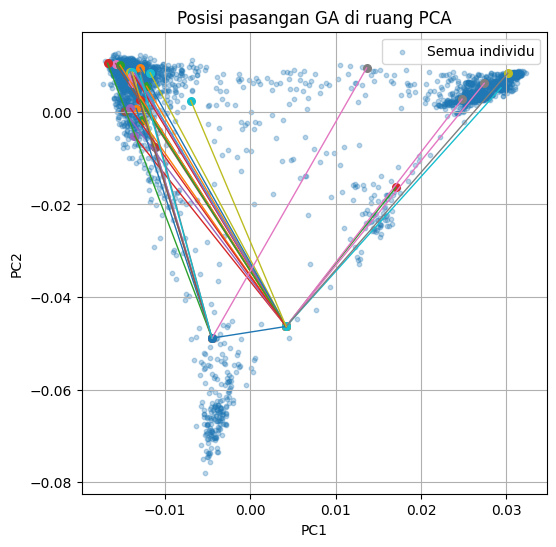

In [61]:
# =========================================
# Evaluasi 3: Visualisasi di ruang PCA
# (menggunakan dua PC pertama)
# =========================================

# Ambil dua PC pertama dari PC_use
pc2 = PC_use[:, :2]   # shape (n_samples, 2)

plt.figure(figsize=(6,6))

# Semua individu: titik abu-abu
plt.scatter(pc2[:, 0], pc2[:, 1], alpha=0.3, s=10, label='Semua individu')

# Pasangan GA (misal 20 teratas)
for _, row in df_results.iterrows():
    i = int(row['idx1'])
    j = int(row['idx2'])
    x = [pc2[i, 0], pc2[j, 0]]
    y = [pc2[i, 1], pc2[j, 1]]

    # garis yang menghubungkan dua individu pasangan GA
    plt.plot(x, y, linewidth=1)

    # titik pasangan GA (lebih tebal)
    plt.scatter(pc2[[i, j], 0], pc2[[i, j], 1], s=30)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Posisi pasangan GA di ruang PCA')
plt.grid(True)
plt.legend()
plt.show()
